In [1]:
import datetime
import re
import pandas as pd
import numpy as np
import string
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as bs


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
data_ = pd.read_excel('drama data 500.xlsx')
header = {'authority' : 'www.google.com', 
          'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15',
         'x-client-data': 'CIe2yQEIorbJAQjEtskBCKmdygEImbXKAQj2x8oBCOfIygEI6cjKAQirycoBCNvVygEI+tjKAQ=='}
    

def get_google_soup(drama_title):
    
    url = 'https://www.google.com/search?q={title}(드라마)'.format(title = drama_title)
    html = requests.get(url, headers=header)
    soup = bs(html.content, 'html.parser')
    
    return soup

def get_soup(url):
    html = requests.get(url, headers=header)
    soup = bs(html.content, 'html.parser')
    
    return soup

def parse_urls(drama_title):
    
    soup = get_google_soup(drama_title)
    urls = {}
    
    for a in soup.find_all('a'):
        try:
            if a['href'].startswith('https') and 'google' not in a['href']:
                new_url = a['href']
                html = requests.get(new_url)
                soup = bs(html.content, 'html.parser')
                urls[soup.title.text.upper()] = new_url
                
        except:
            pass
    return urls

def rectifier(urls, drama_title):
    pieces_of_title = drama_title.split()
    max_keys = []
    for piece_of_title in pieces_of_title:
        keys = []
        for key in urls.keys():
            if piece_of_title in key:
                keys.append(key)
        if len(keys) > len(max_keys):
            max_keys = keys
    return max_keys

def related_url(urls, drama_title):
    related = []
    max_keys = rectifier(urls, drama_title)
    for key in max_keys:
        related.append(urls[key])
    return related

def save_text(related_urls, title):
    whole_text = ''
    for url in related_urls:
        soup = get_soup(url)
        text = soup.text
        text = re.sub(rf'[0-9*]|[{string.punctuation}]|[A-z*]', '', text)
        whole_text += '\n'+text
        
    with open('{}.txt'.format(title), 'w') as f:
        f.write(whole_text)
        
def get_drama_factors(title, keyword_list):
    
    
    drama_factor = {}
    with open('textdata/{}.txt'.format(title) , 'r') as f:
        gen = (text for text in f)
        for i in gen: 
            i = re.sub('《.*》','',i)
            i = re.sub(title,'',i)
            for word in i.split():
                if word in keyword_list:
                    try:
                        drama_factor[word] += 1
                    except:
                        drama_factor[word] = 1
    return drama_factor
                        

In [220]:
drama_data = {}

keyword_list1 = ['로맨스','로맨틱','코미디','멜로','가족','결혼','판타지','범죄','액션','볍률',
                '스릴러','복수','청춘','불륜','수사','휴먼','휴머','막장','추리']
keyword_list2 = ['오피스','성장','변호사','엘리트','천재','의사','행복','식당','골목'
                '사랑','상위','판사','수술','동네']
keyword_list3 = ['심리','추적','미스터리','첩보','로코','힐링','경찰','병원']
keyword_list4 = ['따뜻','감동','치유','왕자','임금']

keyword_list = keyword_list1 + keyword_list2 # + keyword_list3 + keyword_list4

keyword_list = ['따뜻','감동','치유','힐링','훈훈','행복','감사','사랑','진심','우정','멜로','청춘','도전','열정','기쁨']

for title in tqdm(data_['작품명']):
    try:
        drama_factor = get_drama_factors(title, keyword_list)
        drama_data[title] = drama_factor
    except:
        pass
    
dataframe = pd.DataFrame(drama_data).fillna(0).T

In [221]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
drama_keyword = pd.DataFrame(scaler.fit_transform(dataframe), index=dataframe.index, columns=dataframe.columns)

# k-means

In [222]:
from sklearn.cluster import KMeans

clusters = 12

kmeans = KMeans(n_clusters=clusters)
kmeans.fit(drama_keyword)

drama_dict = {}
for k, drama in zip(kmeans.labels_, drama_keyword.index):
    try:
        lists = drama_dict[k]
        lists.append(drama)
        drama_dict[k] = lists
    except:
        drama_dict[k] = [drama]

# Heat map

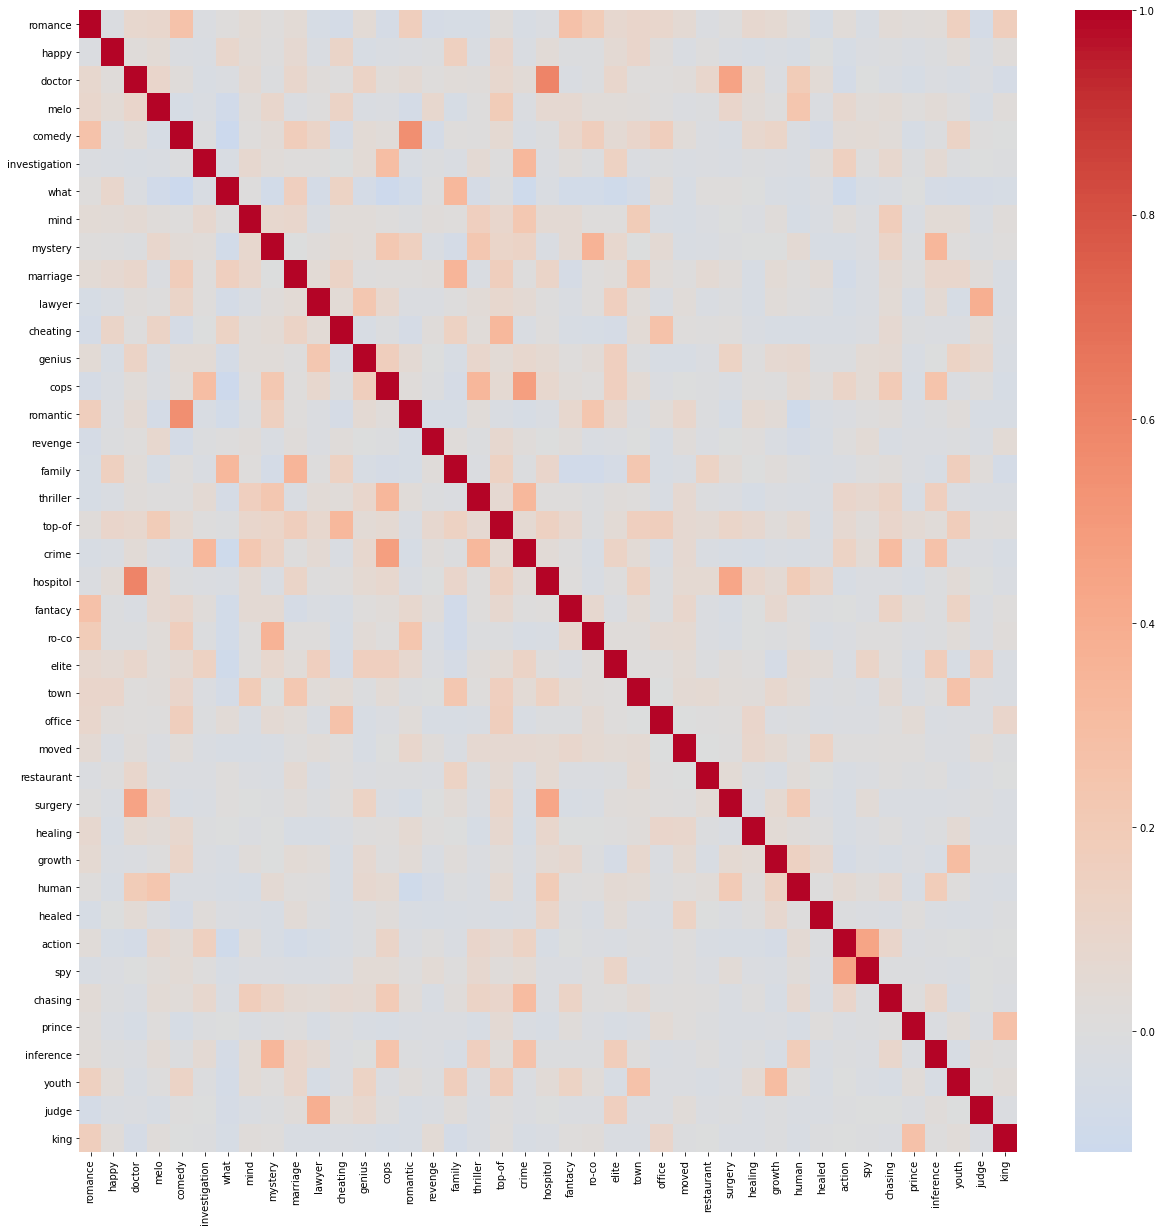

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

new_index = ['romance', 'happy','doctor','melo','comedy','investigation','what','mind','mystery',
            'marriage','lawyer','cheating','genius','cops','romantic','revenge','family',
            'thriller', 'top-of','crime','hospitol','fantacy','ro-co','elite','town','office',
            'moved','restaurant','surgery','healing','growth','human','healed','action',
            'spy','chasing','prince','inference','youth','judge','king']
drama_keyword.columns = new_index
plt.figure(figsize=(21,21))
plt.xlabel(15)
plt.ylabel(15)
sns.heatmap(drama_keyword.corr(),cmap = 'coolwarm', center=0)
plt.show()

# K-means

In [223]:
from sklearn.cluster import KMeans

first = pd.read_excel('base_data.xlsx', index_col=[0])
first_and_keys = pd.concat([first[['first rating']], drama_keyword], axis = 1).dropna()
X = first_and_keys.loc[:, first_and_keys.columns != 'first rating']
y = first_and_keys.loc[:, 'first rating']


def kmeans(clusters, X):

    kmeans = KMeans(n_clusters=clusters, max_iter= 3000)
    kmeans.fit(X)

    drama_dict = {}
    for k, drama in zip(kmeans.labels_, X.index):
        lists = drama_dict.setdefault(k, [])
        lists.append(drama)
    
    return drama_dict


def plot_kmean(clusters, X):
    x_axis = []
    y_axis = []
    drama_dict = kmeans(clusters, X)
    for i in range(clusters):

        drama_list = drama_dict[i]
        for drama in drama_list:
            y_axis.append(y[drama])
            x_axis.append(i)
            
    plt.figure(figsize=(12,12))
    plt.title("Clusters : {}".format(clusters), fontsize = 25)
    plt.ylabel('First rating', fontsize=15)
    plt.xlabel('Clusters (unnamed)', fontsize=15)
    plt.scatter(x_axis, y_axis)
    plt.show()

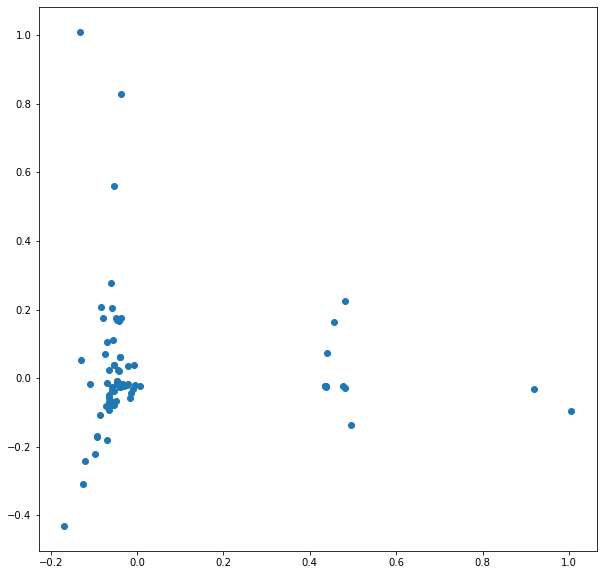

In [224]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
x = pca.fit_transform(X)
plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1])
plt.show()

In [225]:
integrated = np.concatenate((x, np.array([y]).T),axis = 1)
integrated = integrated[integrated[:,2].argsort()]

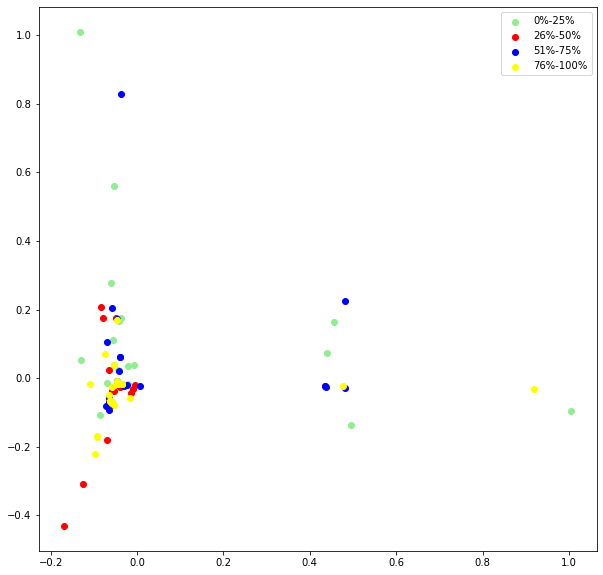

In [226]:
arrays = integrated
a = arrays[:33]
b = arrays[34:66]
c = arrays[67:99]
d = arrays[100:]


plt.figure(figsize=(10,10))
plt.scatter(a[:,0], a[:,1], c='lightgreen', label = '0%-25%')
plt.scatter(b[:,0], b[:,1], c='red', label = '26%-50%')
plt.scatter(c[:,0], c[:,1], c='blue', label = '51%-75%')
plt.scatter(d[:,0], d[:,1], c='yellow', label = '76%-100%')
plt.legend()
plt.show()


In [32]:
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from keras.models import Sequential
from keras.layers import Dense
import keras

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5376      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 15,985
Trainable params: 15,985
Non-trainable params: 0
_________________________________________________________________


In [33]:
%time
train_rmse = []
test_rmse = []

for i in tqdm(range(30)):
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, epochs=1, verbose=0)
    
    train_pred = model.predict(X_train)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))z

    test_pred = model.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


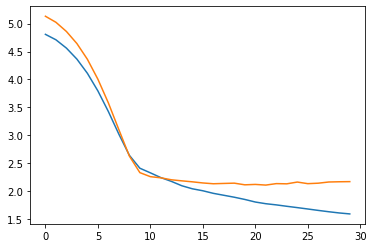

In [34]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.show()

In [41]:
prediction = model.predict(X_test)
for pred, targ in zip(prediction, y_test):
    pred = round(pred[0])
    diff = round(pred - targ, 1)
    print('pred : {pred}, targ : {targ}, diff : {diff}'.format(pred=pred, targ=targ, diff=diff))

pred : 6, targ : 7.1, diff : -1.1
pred : 5, targ : 4.0, diff : 1.0
pred : 3, targ : 3.6, diff : -0.6
pred : 5, targ : 7.8, diff : -2.8
pred : 4, targ : 3.9, diff : 0.1
pred : 4, targ : 9.5, diff : -5.5
pred : 3, targ : 10.4, diff : -7.4
pred : 3, targ : 4.8, diff : -1.8
pred : 6, targ : 4.7, diff : 1.3
pred : 4, targ : 1.8, diff : 2.2
pred : 7, targ : 6.0, diff : 1.0
pred : 3, targ : 4.1, diff : -1.1
pred : 5, targ : 4.6, diff : 0.4
pred : 4, targ : 2.9, diff : 1.1
pred : 5, targ : 3.1, diff : 1.9
pred : 4, targ : 4.8, diff : -0.8
pred : 4, targ : 5.9, diff : -1.9
pred : 5, targ : 5.8, diff : -0.8
pred : 3, targ : 2.4, diff : 0.6
pred : 3, targ : 3.7, diff : -0.7
pred : 6, targ : 6.7, diff : -0.7
pred : 4, targ : 3.6, diff : 0.4
pred : 5, targ : 6.3, diff : -1.3
pred : 5, targ : 2.7, diff : 2.3
pred : 4, targ : 3.5, diff : 0.5
pred : 4, targ : 2.3, diff : 1.7
pred : 5, targ : 3.2, diff : 1.8
